## SIMULATOR AND SUMMARY STATISTICS

In [1]:
import os
#os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
# Load the minimum required library to run the functions
#from Utils_functions import *
from InternalLibrary.StatisticalFunctions import *
from InternalLibrary.SimulatorPackage import Simulator_noGPU

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch

from tqdm import tqdm
import _pickle as pickle


In [3]:
dt = 1e-6# The time step size for the simulation. This is the amount of time that passes in the model for each step of the simulation
Sample_frequency = 25_000 # The sampling frequency. This is the number of samples that are recorded per unit time
DeltaT = 1/Sample_frequency # The sampling period. This is the amount of time that passes in the model between each sample that is recorded
TotalT = 1 # The total time for the simulation. This is the total amount of time that the simulation is intended to represent
n_sim = int(500)
t_corr = TotalT/50

In [4]:
time_steps_amount = np.int64(TotalT/dt) # Number of steps
sampled_point_amount = np.int64(TotalT/DeltaT) # Number of sampled points
sampling_delta_time_steps = np.int64(DeltaT/dt) # Number of steps between samples
t = np.linspace(0., TotalT,sampled_point_amount) # Time array

In [5]:
# Limits for the parameters (kbT=3.8 pN nm)
prior_limits = {
    "mu_y": [1e4, 140e4],
    "k_y": [1.5e-2, 30e-2],
    "k_int": [1e-3, 6e-3],
    "tau": [2e-2, 20e-2],
    "eps": [0.5, 6],
}

In [6]:
# Dummy call to compile the simulator
theta, theta_torch = get_theta_from_prior(prior_limits, 1)
Simulator_noGPU(0.1, 0.1, 0.5, theta);

In [7]:
%%time
theta, theta_torch = get_theta_from_prior(prior_limits, n_sim)
x_trace, y_trace, f_trace = Simulator_noGPU(dt, DeltaT, TotalT, theta)

CPU times: user 1min 2s, sys: 106 ms, total: 1min 2s
Wall time: 1min 2s


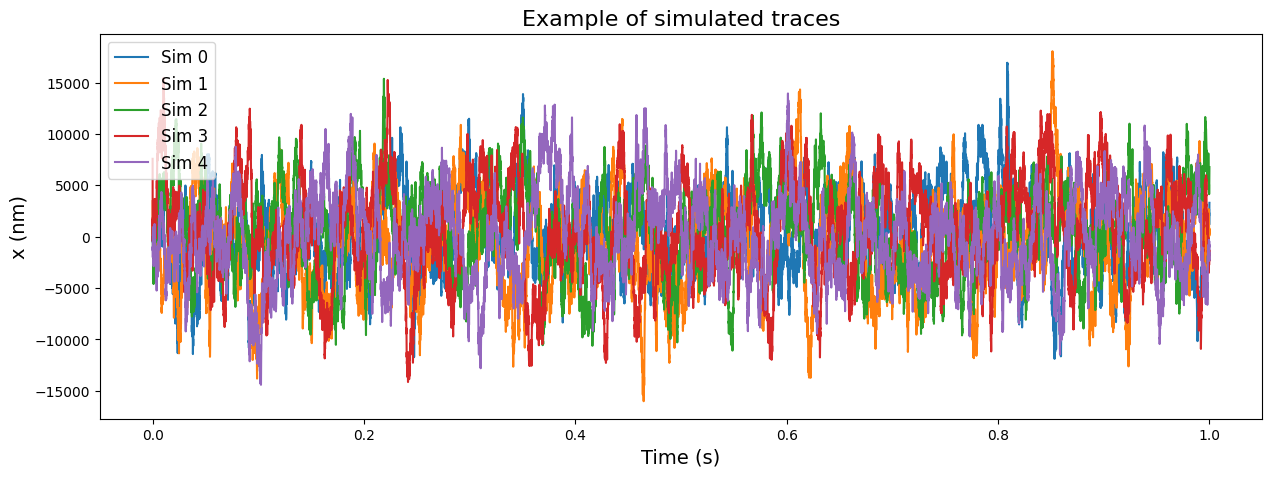

In [8]:
plt.figure(figsize=(15, 5))
for i in range(min([n_sim, 5])):
    plt.plot(t, x_trace[i], label=f"Sim {i}")
plt.title("Example of simulated traces", fontsize=16)
plt.xlabel("Time (s)", fontsize=14)
plt.ylabel("x (nm)", fontsize=14)
plt.legend(fontsize=12);

In [9]:
%%time
# Pipeline from the n_sim simulations to the be ready for training
for i in range(n_sim):
    # Here handle the local simulations
    summary_stats = compute_summary_statistics(x_trace[i], theta[:, i])
    
    # From here pipeline after reading from files
    s_i = select_summary_statistics(summary_stats, ["Cxx", "s_redx", "psdx", "hermite"])
    if i == 0:
        s_tot = s_i
        theta_tot = torch.from_numpy(summary_stats["theta"]).to(torch.float32)
    else:
        s_tot = torch.cat((s_tot, s_i), dim=0)
        theta_tot = torch.cat((theta_tot, torch.from_numpy(summary_stats["theta"]).to(torch.float32)), dim=1)

theta_tot = theta_tot.T

print("s_tot.shape", s_tot.shape)
print("theta_tot.shape", theta_tot.shape)
    

s_tot.shape torch.Size([500, 1520])
theta_tot.shape torch.Size([500, 5])
CPU times: user 38.7 s, sys: 38.3 ms, total: 38.7 s
Wall time: 12.6 s


## INFERENCE

In [10]:
from sbi import analysis as analysis
from sbi import utils as utils
from sbi.inference import SNPE, simulate_for_sbi, infer
from sbi.utils.user_input_checks import (
    check_sbi_inputs,
    process_prior,
    process_simulator,
)

In [11]:
# Prior distribution for sbi
prior_box = get_prior_box(prior_limits)
prior, num_parameters, prior_returns_numpy = process_prior(prior_box)

In [12]:
# Call infer form sbi
infer = SNPE(prior=prior)
inferece = infer.append_simulations(theta_tot, s_tot)

In [13]:
%%time
# Train the model
density_estimator = infer.train()
posterior = infer.build_posterior(density_estimator)

 Neural network successfully converged after 30 epochs.CPU times: user 16.4 s, sys: 63.6 ms, total: 16.4 s
Wall time: 4.72 s


In [14]:
# Get the observed trace
theta_true, theta_torch_true = get_theta_from_prior(prior_limits, 1)
x_trace_true, y_trace_true, f_trace_true = Simulator_noGPU(dt, DeltaT, TotalT, theta_true)
print("theta_true.shape: ", theta_true.shape)
print("x_trace_true.shape: ", x_trace_true.shape)

theta_true.shape:  (5, 1, 1)
x_trace_true.shape:  (1, 24999)


In [15]:
# Compute the summary statistics for the observed trace
summary_stats_true = compute_summary_statistics(x_trace_true[0], theta_true[:, 0])
s_true = select_summary_statistics(summary_stats_true, ["Cxx", "s_redx", "psdx", "hermite"])

In [16]:
# Sample from the posterior
samples = posterior.sample((int(1e2),), x=s_true)

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

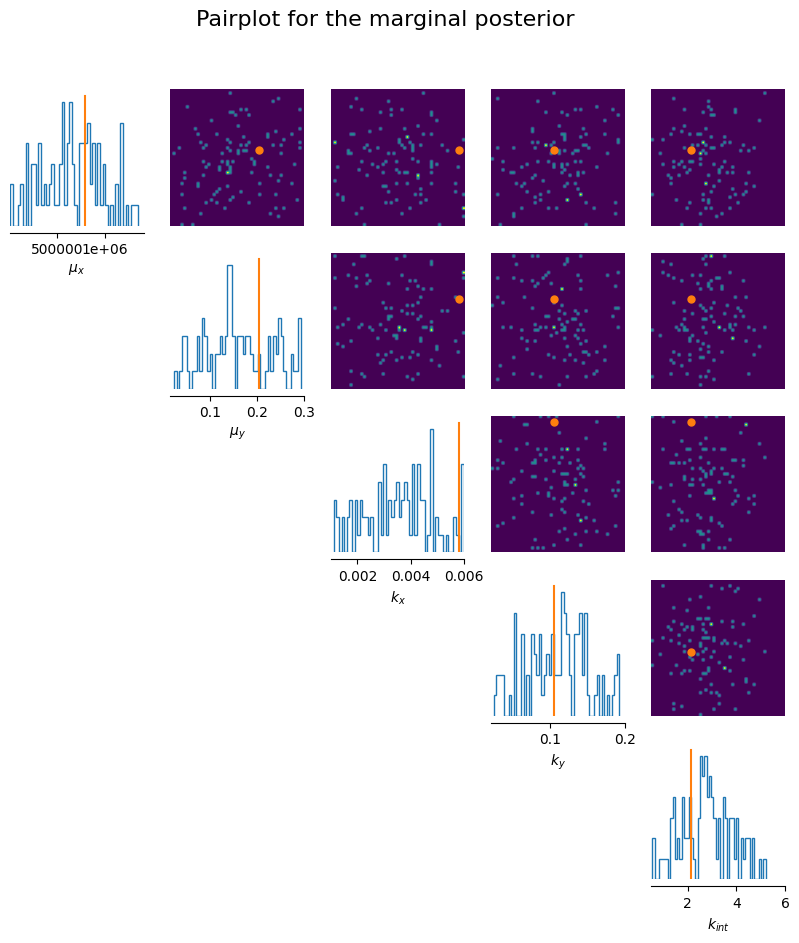

In [17]:
# Pairplot
label_theta = [r"$\mu_x$", r"$\mu_y$", r"$k_x$", r"$k_y$", r"$k_{int}$", r"$\tau$", r"$\varepsilon$", r"$D_x$", r"$D_y$"]
prior_limits_list = get_prior_limit_list(prior_limits)
_ = analysis.pairplot(samples, points=[theta_torch_true.T], 
                      limits=prior_limits_list, figsize=(10, 10), 
                      title = "Pairplot for the marginal posterior",
                      labels=label_theta)

## ENTROPY PRODUCTION & PERFORMANCES

These are the formulas used to compute the entropy production
$$
S = \sum_{t=0}^{N_{\text{timesteps}}-2} \left( \text{data}_{t+1} - \text{data}_{t} \right) \cdot F\left( \frac{\text{data}_{t+1} + \text{data}_{t}}{2} \right) \cdot D^{-1}\left( \frac{\text{data}_{t+1} + \text{data}_{t}}{2} \right)
$$
$$
\sigma = \frac{{\mu_y \cdot \varepsilon^2}}{{1 + k_y \cdot \mu_y \cdot \tau - \frac{{k_{int}^2 \cdot \mu_x \cdot \mu_y \cdot \tau^2}}{{1 + k_x \cdot \mu_x \cdot \tau}}}}
$$

### Analytical entropy

Firstly, let's try looking at the distribution of sigma obtained just sampling the parameters from the prior (i.e. the distribution of "true sigma")

In [24]:
# Function to test, when ready move to Utils_functions.py
# TO BE FIXED
def get_centroids_from_samples(samples):
    mean_params = np.array([])
    mode_params = np.array([])

    for i in range(9):
        # Retrive the samples for the parameter i
        params = samples[:,i].numpy()
        # Compute the mean
        mean_params = np.concatenate((mean_params, [np.mean(params)]))
        # Compute the mode
        hist, bin_edges = np.histogram(params, bins=int(np.sqrt(params.shape[0])))
        max_index = np.argmax(hist)
        mode = (bin_edges[max_index] + bin_edges[max_index+1])/2
        mode_params = np.concatenate((mode_params, [mode]))

    mean_params = mean_params.reshape(9, 1, 1)
    mode_params = mode_params.reshape(9, 1, 1)
    return mean_params, mode_params

In [23]:
# Simply generating thetas from the prior and computing the entropy
n = int(1e5)
sigmas_from_prior = []

for i in range(n):
    theta, _, _ = get_theta_from_prior(prior_limits, 1)
    sigma = compute_entropy_2(theta, 1)[0][0][0]
    sigmas_from_prior.append(sigma)

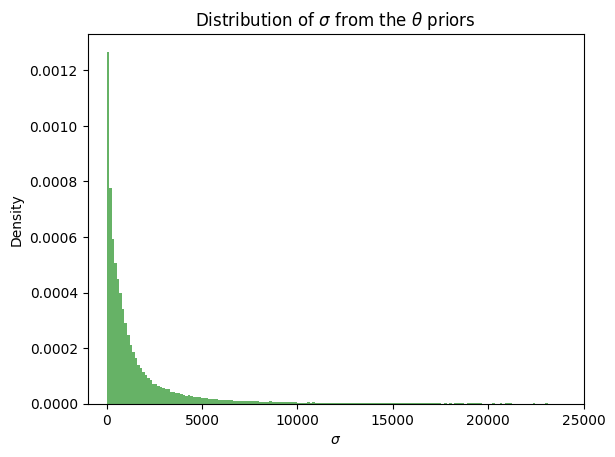

In [24]:
plt.title(r"Distribution of $\sigma$ from the $\theta$ priors")
plt.xlabel(r"$\sigma$")
plt.ylabel("Density")
plt.hist(sigmas_from_prior, bins=1000, density=True, alpha=0.6, color='g')
plt.xlim([-1e3, 25e3])
plt.show();

Let's try to compare the analytical entropy production directly looking at the best estimates of the inferred parameters. 

In [25]:
# Test analytical entropy production on single realization
sigma_true_2, _, = compute_entropy_2(theta_true, 1)
sigma_est_2_mean, _, = compute_entropy_2(mean_params, 1)
sigma_est_2_mode, _, = compute_entropy_2(mode_params, 1)
print("Estimates for the analytical entropy production:")
print(f"True: %.2f, Mean: %.2f, Mode: %.2f" % (sigma_true_2[0][0], sigma_est_2_mean[0][0], sigma_est_2_mode[0][0]))

Estimates for the analytical entropy production:
True: 1216.04, Mean: 733.01, Mode: 727.60


Let's make some statistics out of it. In the following, we'll use multiple indipendent test sets of theta. For each of them, we'll sample the posterior multiple time to get a distribution of the estimated inferred theta. From them, we compute sigma. The net result is a statistics of the inferred sigma (based on the mode of the marginal distributions) over multiple tests. 

In [26]:
# Function to test: when ready, move to Utils_functions.py
def comparison_sigma_analytical(n_test, n_sim_obs, 
                                prior_limits=prior_limits, list_stat=list_stat, t_corr=t_corr, t=t, DeltaT=DeltaT, dt=dt):
    sigma_true_array = np.zeros((n_test, 1))
    sigma_est_array = np.zeros((n_test, n_sim_obs))

    for i in range(n_test):
        # Get the true parameters and the n_sim_obs traces
        theta_true, _, _ = get_theta_from_prior(prior_limits, n_sim=n_sim_obs)
        x_trace_true, f_trace_true, _ = Simulator_noGPU(dt, DeltaT, TotalT, n_sim_obs, theta_true)
            
        # Compute the (true) entropy production analytically
        sigma_true, _, = compute_entropy_2(theta_true, 1)
        sigma_true_array[i] = sigma_true[0][0]

        # Get the summary statistics
        s = get_summary_statistics(list_stat, x_trace_true, f_trace_true, theta_true, DeltaT, 3, t, t_corr)

        for j in range(n_sim_obs):
            # Sample from the posterior
            samples = posterior.sample((int(1e5),), x=s[j, :], show_progress_bars=False)

            # Get the mean and mode parameters
            mean_params, mode_params = get_centroids_from_samples(samples)

            # Compute the entropy production analytically
            sigma_est_mode, _, = compute_entropy_2(mode_params, 1)
            sigma_est_array[i, j] = sigma_est_mode[0][0]    
    
    return sigma_true_array, sigma_est_array

In [27]:
%%time
# Test on analytical entropy production on multiple realizations
n_test = 2  # Number of test realizations
n_sim_obs = 5  # Number of observed trace per realization

sigma_true_array, sigma_est_array = comparison_sigma_analytical(n_test, n_sim_obs)

CPU times: user 39min 57s, sys: 18min 39s, total: 58min 36s
Wall time: 14min 42s


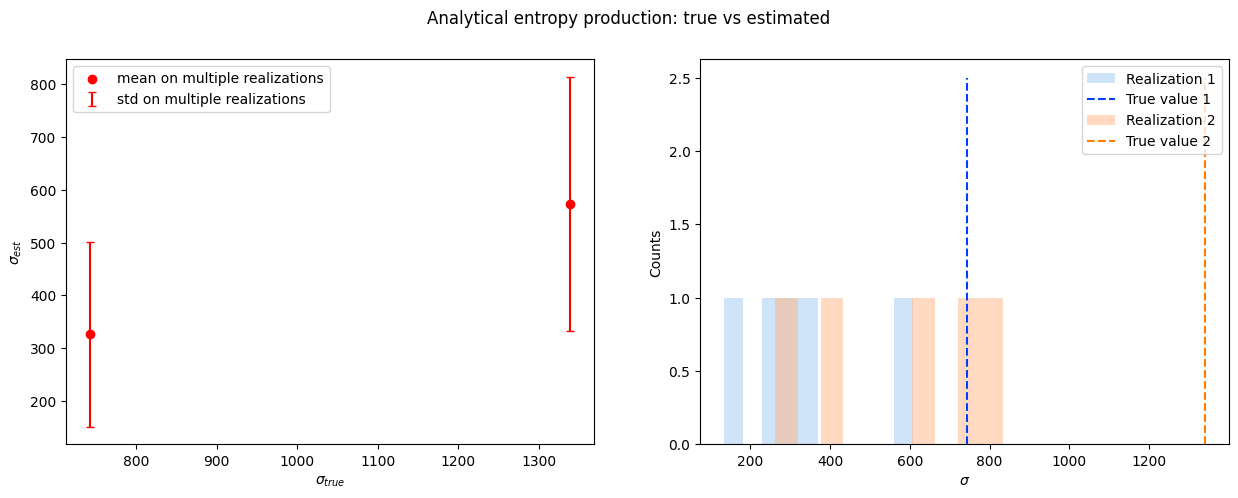

In [28]:
plt.figure(figsize=(15, 5))
plt.suptitle("Analytical entropy production: true vs estimated")

plt.subplot(121)
plt.xlabel(r"$\sigma_{true}$")
plt.ylabel(r"$\sigma_{est}$")
plt.scatter(sigma_true_array, np.mean(sigma_est_array, axis=1), label='mean on multiple realizations', color='red')
plt.errorbar(sigma_true_array, np.mean(sigma_est_array, axis=1), yerr=np.std(sigma_est_array, axis=1, ddof=1), 
             fmt=' ', capsize=3, label='std on multiple realizations', color='red')
#plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.legend()

plt.subplot(122)
color_palette_1 = sns.color_palette("pastel", n_test)
color_palette_2 = sns.color_palette("bright", n_test)

for i in range(n_test):
    plt.hist(sigma_est_array[i, :], alpha=0.5, label=f"Realization {i+1}", color=color_palette_1[i])
    plt.vlines(sigma_true_array[i], 0, n_sim_obs/n_test, color=color_palette_2[i], linestyle='--', label=f'True value {i+1}')
plt.xlabel(r"$\sigma$")
plt.ylabel("Counts")

plt.legend();

Now let's try a different approach. Instead of looking at the best estimates for the parameters, we'll use the entire posterior (of a single realization) to build a distribution of sigma.

In [29]:
# Obtain the samples from the posterior of a single realization
theta_true, theta_torch_true, prior_box_true = get_theta_from_prior(prior_limits, 1)
x_trace_true, f_trace_true, y_trace_true = Simulator_noGPU(dt, DeltaT, TotalT, 1, theta_true)
s = get_summary_statistics(list_stat, x_trace_true, f_trace_true, theta_true, DeltaT, 3, t, t_corr)

samples = posterior.sample((int(1e5),), x=s)

Drawing 100000 posterior samples:   0%|          | 0/100000 [00:00<?, ?it/s]

In [30]:
# Get the true entropy production
sigma_true_2 = compute_entropy_2(theta_true, 1)[0][0][0]

# Get the statistics of sigma directly out of the samples
sigma_samples = array([])
#sanity_check = array([])

for i in range(samples.shape[0]):
    sample = samples[i,:].numpy().reshape(9,1,1)
    #sanity_check = concatenate((sanity_check, [sample[0][0][0]]))
    sigma = compute_entropy_2(list(sample), 1)[0][0][0]
    sigma_samples = concatenate((sigma_samples, [sigma]))

True value: 1370.39


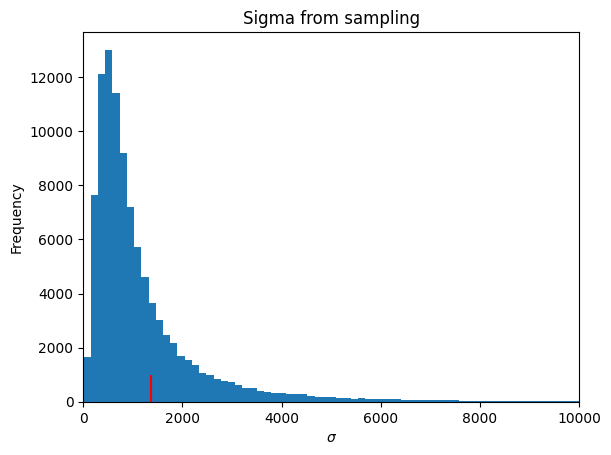

In [31]:
plt.xlim(0, 1e4)
plt.vlines(sigma_true_2, 0, 1e3, color='r')
print("True value: %.2f" % sigma_true_2)
plt.xlabel(r"$\sigma$")
plt.ylabel("Frequency")
plt.title("Sigma from sampling")
plt.hist(sigma_samples, bins=int(np.sqrt(len(sigma_samples))));

TO DO (when we'll have decent results): do the same but with multiple tests

### Experimental entropy

Fistly, let's look at the experimental entropy distribution obtain simply generating samples from the prior.

In [7]:
%%time
# Compute the obtained entropy production priors, individually for each simulation
emp_sigma_from_prior = np.array([])
sigma_from_prior = np.array([])

n_sim = int(1e4)
n_batch = int(1e2)

# n_sim = int(1e2)
# n_batch = int(1e1)

print("Computing %d simulations in %d batches" % (n_batch*(n_sim//n_batch), n_sim//n_batch))
for i in tqdm(range(n_sim//n_batch)):
    # Simulate the dynamics
    theta, theta_torch = get_theta_from_prior(prior_limits, n_sim//n_batch)
    x_trace, y_trace, f_trace = Simulator_noGPU(dt, DeltaT, TotalT, theta)

    # Compute the empirical entropy production
    _, _, _, emp_sigma = ComputeEmpiricalEntropy(x_trace, y_trace, f_trace, theta, n_batch)
    emp_sigma_from_prior = np.concatenate((emp_sigma_from_prior, emp_sigma))

    # Compute the analytical entropy production
    sigma_vec, _ = ComputeTheoreticalEntropy(theta, n_batch)
    sigma_from_prior = np.concatenate((sigma_from_prior, np.squeeze(sigma_vec)))

    # Clear the memory (for safety)
    #del theta, theta_torch, prior_box, x_trace, f_trace, y_trace
    #del emp_sigma_vec, sigma_vec

Computing 10000 simulations in 100 batches


100%|██████████| 100/100 [10:30<00:00,  6.31s/it]

CPU times: total: 10min 15s
Wall time: 10min 30s


In [8]:
action = "save"

if action == "save":
    with open("data/sigma_from_prior.pkl", 'wb') as f:
        pickle.dump(sigma_from_prior, f)

    with open("data/emp_sigma_from_prior.pkl", 'wb') as f:
        pickle.dump(emp_sigma_from_prior, f)

    with open("data/theta.pkl", 'wb') as f:
        pickle.dump(theta, f)

if action == "load":
    with open("data/sigma_from_prior.pkl", 'rb') as f:
        sigma_from_prior = pickle.load(f)

    with open("data/emp_sigma_from_prior.pkl", 'rb') as f:
        emp_sigma_from_prior = pickle.load(f)

    with open("data/theta.pkl", 'rb') as f:
        theta = pickle.load(f)

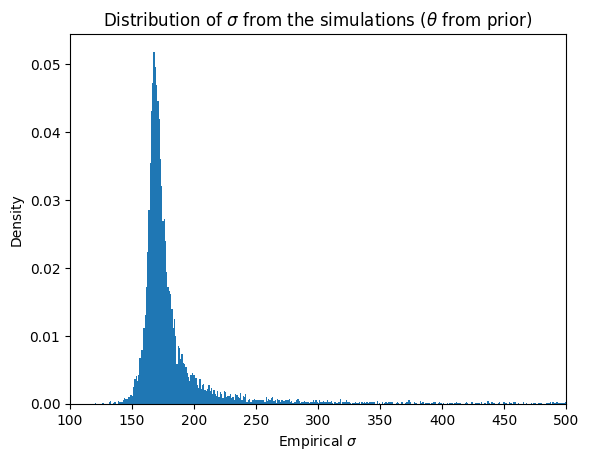

In [10]:
plt.hist(emp_sigma_from_prior, bins=int(1e3), density=True)
plt.xlim(100, 500)
plt.xlabel(r"Empirical $\sigma$")
plt.ylabel("Density")
plt.title(r"Distribution of $\sigma$ from the simulations ($\theta$ from prior)");

Let's compare the empirical and analytical sigma

<>:4: SyntaxWarning: invalid escape sequence '\s'
<>:4: SyntaxWarning: invalid escape sequence '\s'
C:\Users\Lorenzo Vigorelli\AppData\Local\Temp\ipykernel_4828\3180162989.py:4: SyntaxWarning: invalid escape sequence '\s'
  plt.title("Analytical vs Empirical $\sigma$ (from prior)");


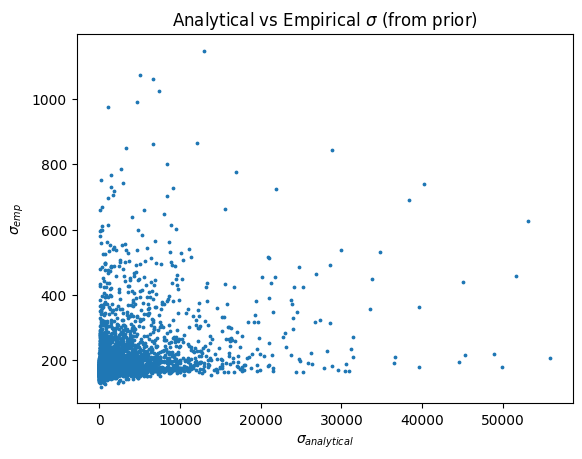

In [11]:
plt.scatter(sigma_from_prior, emp_sigma_from_prior, s=3)
plt.xlabel(r"$\sigma_{analytical}$")
plt.ylabel(r"$\sigma_{emp}$")
plt.title("Analytical vs Empirical $\sigma$ (from prior)");

<>:2: SyntaxWarning: invalid escape sequence '\s'
<>:2: SyntaxWarning: invalid escape sequence '\s'
C:\Users\Lorenzo Vigorelli\AppData\Local\Temp\ipykernel_4828\1558990474.py:2: SyntaxWarning: invalid escape sequence '\s'
  plt.title("Distribution of the analytical $\sigma$ from the prior", fontsize=20)


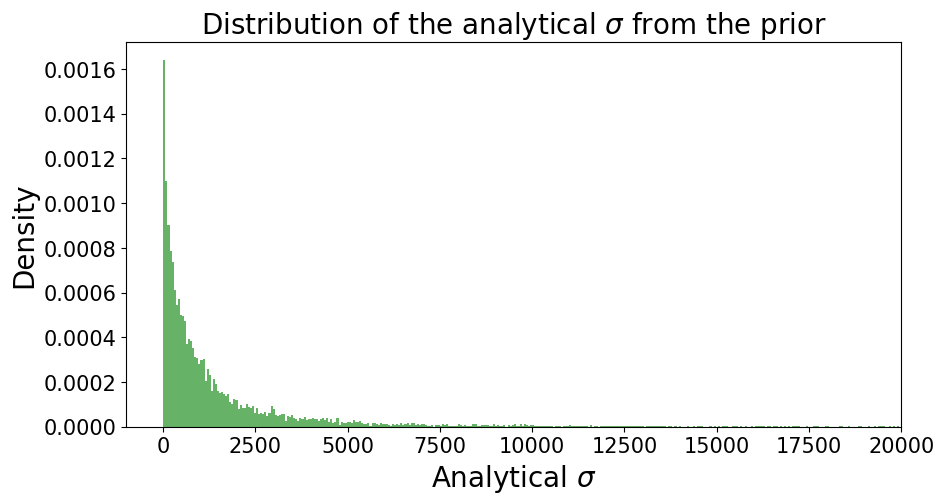

In [12]:
plt.figure(figsize=(10, 5))
plt.title("Distribution of the analytical $\sigma$ from the prior", fontsize=20)
plt.xlabel(r"Analytical $\sigma$", fontsize=20)
plt.ylabel("Density", fontsize=20)
plt.hist(sigma_from_prior, bins=int(1e3), density=True, alpha=0.6, color='g')
plt.xlim(-1000, 20000)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show();


Now let's look at the distribution of the empirical sigma for fixed parameters

In [35]:
# %%time
# n_test = int(2e2)
# emp_sigma_fixed_theta = []

# # Sample the prior (once!)
# theta, theta_torch, prior_box = get_theta_from_prior(prior_limits, 1)

# # Obtain the entropy production for different simulations
# for i in tqdm(range(n_test)):
#     x_trace, f_trace, y_trace = Simulator_noGPU(dt, DeltaT, TotalT, 1, theta)
#     emp_sigma, _, _, _ = compute_entropy_production(x_trace, y_trace, f_trace, theta, 1)
#     emp_sigma_fixed_theta.append(emp_sigma)

100%|██████████| 200/200 [01:30<00:00,  2.21it/s]

CPU times: user 1min 30s, sys: 215 ms, total: 1min 31s
Wall time: 1min 30s


In [13]:
%%time
n_test = int(1e2)  # Number of independent tests
n_trial = int(1e2)  # Number of runs for each set of parameters

emp_sigma_fixed_theta = np.zeros((n_test, n_trial))

for i in tqdm(range(n_test)):
    # Sample the prior (once!)
    theta, theta_torch, prior_box = get_theta_from_prior(prior_limits, 1)
    theta_tile = np.tile(theta, (n_trial, 1))

    # Obtain the entropy production for different simulations
    x_trace, f_trace, y_trace = Simulator_noGPU(dt, DeltaT, 5, n_trial, theta_tile)
    _, _, _, emp_sigma_vec = compute_entropy_production(x_trace, y_trace, f_trace, theta_tile, n_trial)
    emp_sigma_fixed_theta[i, :] = emp_sigma_vec

100%|██████████| 100/100 [1:28:48<00:00, 53.29s/it]

CPU times: user 1h 28min 49s, sys: 31.1 s, total: 1h 29min 20s
Wall time: 1h 28min 48s


In [11]:
# Save the data
action = "load"

if action == "save":
    with open("data/emp_sigma_fixed_theta.pkl", 'wb') as f:
        pickle.dump(emp_sigma_fixed_theta, f)

if action == "load":
    with open("data/emp_sigma_fixed_theta.pkl", 'rb') as f:
        emp_sigma_fixed_theta = pickle.load(f)

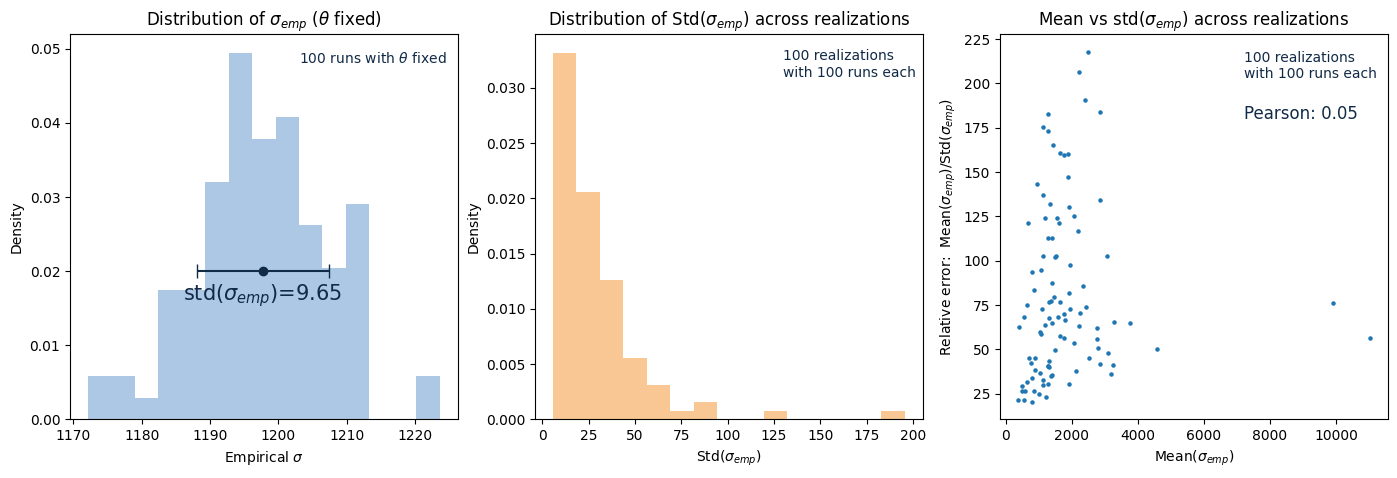

In [25]:
plt.figure(figsize=(17, 5))

plt.subplot(131)
plt.hist(emp_sigma_fixed_theta[9, :], bins=15, density=True, color='#ACC8E5')
plt.xlabel(r"Empirical $\sigma$")
plt.ylabel("Density")
plt.title(r"Distribution of $\sigma_{emp}$ ($\theta$ fixed)")
m = np.mean(emp_sigma_fixed_theta[9, :])
s = np.std(emp_sigma_fixed_theta[9, :])
plt.errorbar(m, 0.02, xerr=s, fmt='o', color='#112A46', capsize=5)
plt.text(1186, 0.016, r"std($\sigma_{emp}$)=%.2f" % s, color='#112A46', fontsize=15)
plt.text(1203, 0.048, r"%d runs with $\theta$ fixed" % emp_sigma_fixed_theta.shape[1], 
         color='#112A46', fontsize=10)

plt.subplot(132)
plt.hist(np.std(emp_sigma_fixed_theta, axis=1), bins=15, density=True, color="#F8C794")
plt.xlabel(r"Std($\sigma_{emp}$)")
plt.ylabel("Density")
plt.title(r"Distribution of Std($\sigma_{emp}$) across realizations")
plt.text(130, 0.031, 
         f"%d realizations \n" % emp_sigma_fixed_theta.shape[0] + "with %d runs each" % emp_sigma_fixed_theta.shape[1], 
         color='#112A46', fontsize=10)

plt.subplot(133)
plt.scatter(np.mean(emp_sigma_fixed_theta, axis=1), 
            np.mean(emp_sigma_fixed_theta, axis=1)/np.std(emp_sigma_fixed_theta, axis=1), s=5)
plt.xlabel(r"Mean($\sigma_{emp}$)")
plt.ylabel(r"Relative error:  Mean($\sigma_{emp}$)/Std($\sigma_{emp}$)")
plt.title(r"Mean vs std($\sigma_{emp}$) across realizations")
plt.text(7200, 203, 
         f"%d realizations \n" % emp_sigma_fixed_theta.shape[0] + "with %d runs each" % emp_sigma_fixed_theta.shape[1], 
         color='#112A46', fontsize=10);
r = np.corrcoef(np.mean(emp_sigma_fixed_theta, axis=1), np.mean(emp_sigma_fixed_theta, axis=1)/np.std(emp_sigma_fixed_theta, axis=1))[0, 1]
plt.text(7200, 180, "Pearson: %.2f" % r, color='#112A46', fontsize=12);

Now let's introduce SBI and the posterior. Firstly, let's sample from a single realization of the sbi and simulate the dynamics (once for computational reasons) to compute the corresponding empirical sigma

In [37]:
%%time
# Get the true parameters (single realization)
theta_true, theta_torch_true, prior_box_true = get_theta_from_prior(prior_limits, 1)
x_trace_true, f_trace_true, y_trace_true = Simulator_noGPU(dt, DeltaT, TotalT, 1, theta_true)

true_sigma_emp = compute_entropy_production(x_trace_true, y_trace_true, f_trace_true, theta_true, 1)[0]

# Sample from the posterior (few points due to later computational cost)
s = get_summary_statistics(list_stat, x_trace_true, f_trace_true, theta_true, DeltaT, 3, t, t_corr)
samples = posterior.sample((int(2e2),), x=s, show_progress_bars=False)

# Compute for each sample the entropy production
emp_sigma_samples = array([])
for i in tqdm(range(samples.shape[0])):
    sample = samples[i,:].numpy().reshape(9,1,1)
    x_trace, f_trace, y_trace = Simulator_noGPU(dt, DeltaT, TotalT, 1, list(sample))
    emp_sigma, _, _, _ = compute_entropy_production(x_trace, y_trace, f_trace, list(sample), 1)
    emp_sigma_samples = concatenate((emp_sigma_samples, [emp_sigma]))

100%|██████████| 200/200 [01:33<00:00,  2.14it/s]

CPU times: user 1min 34s, sys: 270 ms, total: 1min 35s
Wall time: 1min 34s


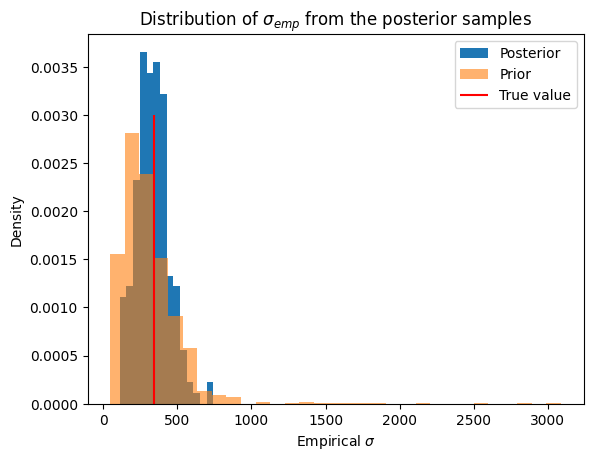

In [46]:
plt.title(r"Distribution of $\sigma_{emp}$ from the posterior samples")
plt.hist(emp_sigma_samples, bins=int(np.sqrt(len(emp_sigma_samples))), density=True, label='Posterior')
plt.hist(emp_sigma_from_prior, bins=int(np.sqrt(len(emp_sigma_from_prior))), density=True, label='Prior', alpha=0.6)
plt.vlines(true_sigma_emp, 0, 0.003, color='r', label='True value')
plt.xlabel(r"Empirical $\sigma$")
plt.ylabel("Density")
plt.legend();

# QUESTIONS
- per calcolare S_red come summary statistics (come fatto da Dresda nel file) usiamo i parametri, non è un bias poi usarla come summary statistics nel neural network durante la SBI?
- qual è la formula corretta per l'entropia? Cosa abbiamo usato noi?
- limiti per la prior distribution sui parametri